In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !aws s3 cp s3://sagemaker-music-genre-gtzan/Simpsons ./datasets/cropped/ --recursive

# Import libs

In [3]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import math
import cv2
import copy
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import os
from keras.preprocessing.image import img_to_array, load_img

from sklearn.metrics import average_precision_score

from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.objectives import categorical_crossentropy

from keras.models import Model
from keras.utils import generic_utils
from keras.engine import Layer, InputSpec
from keras import initializers, regularizers

Using TensorFlow backend.


# Config setting (same as the train)

In [4]:
class Config:

    def __init__(self):

        # Print the process or not
        self.verbose = True

        # Name of base network
        self.network = 'vgg'

        # Setting for data augmentation
        self.use_horizontal_flips = False
        self.use_vertical_flips = False
        self.rot_90 = False

        # Anchor box scales
        # Note that if im_size is smaller, anchor_box_scales should be scaled
        # Original anchor_box_scales in the paper is [128, 256, 512]
        self.anchor_box_scales = [64, 128, 256] 

        # Anchor box ratios
        self.anchor_box_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]

        # Size to resize the smallest side of the image
        # Original setting in paper is 600. Set to 300 in here to save training time
        self.im_size = 300 #300

        # image channel-wise mean to subtract
        self.img_channel_mean = [103.939, 116.779, 123.68]
        self.img_scaling_factor = 1.0

        # number of ROIs at once
        self.num_rois = 4 #4

        # stride at the RPN (this depends on the network configuration)
        self.rpn_stride = 16 #16

        self.balanced_classes = False

        # scaling the stdev
        self.std_scaling = 4.0
        self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]

        # overlaps for RPN ==> used to create the label anchor boxes
        self.rpn_min_overlap = 0.3
        self.rpn_max_overlap = 0.7

        # overlaps for classifier ROIs
        self.classifier_min_overlap = 0.1
        self.classifier_max_overlap = 0.5

        # placeholder for the class mapping, automatically generated by the parser
        self.class_mapping = None

        self.model_path = None

# Parser the data from annotation file (same as train)

In [5]:
def get_data(input_path):

    found_bg = False
    all_imgs = {}

    classes_count = {}

    class_mapping = {}

    visualise = True

    i = 1
    
    with open(input_path,'r') as f:

        print('Parsing annotation files')

        for line in f:
            line_split = line.strip().split(',')

            # Make sure the info saved in annotation file matching the format (path_filename, x1, y1, x2, y2, class_name)
            # Note:
            # One path_filename might has several classes (class_name)
            # x1, y1, x2, y2 are the pixel value of the origial image, not the ratio value
            # (x1, y1) top left coordinates; (x2, y2) bottom right coordinates

            (filename,x1,y1,x2,y2,class_name) = line_split
            filename = filename.replace("\\","//")

#             print(filename,x1,y1,x2,y2,class_name)
    

            if class_name not in classes_count:
                classes_count[class_name] = 1
            else:
                classes_count[class_name] += 1

            if class_name not in class_mapping:
                if class_name == 'bg' and found_bg == False:
                    print('Found class name with special name bg. Will be treated as a background region (this is usually for hard negative mining).')
                    found_bg = True
                class_mapping[class_name] = len(class_mapping)

            if filename not in all_imgs:
                all_imgs[filename] = {}

                img = cv2.imread(filename)
                (rows,cols) = img.shape[:2]
                all_imgs[filename]['filepath'] = filename
                all_imgs[filename]['width'] = cols
                all_imgs[filename]['height'] = rows
                all_imgs[filename]['bboxes'] = []
                # if np.random.randint(0,6) > 0:
                # all_imgs[filename]['imageset'] = 'trainval'
                # else:
                # all_imgs[filename]['imageset'] = 'test'

            all_imgs[filename]['bboxes'].append({'class': class_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)})


        all_data = []
        for key in all_imgs:
            all_data.append(all_imgs[key])

        # make sure the bg class is last in the list
        if found_bg:
            if class_mapping['bg'] != len(class_mapping) - 1:
                key_to_switch = [key for key in class_mapping.keys() if class_mapping[key] == len(class_mapping)-1][0]
                val_to_switch = class_mapping['bg']
                class_mapping['bg'] = len(class_mapping) - 1
                class_mapping[key_to_switch] = val_to_switch

        return all_data, classes_count, class_mapping

# Customize layers and build the model (same as train)

## Define ROI Pooling Convolutional Layer

In [6]:
class RoiPoolingConv(Layer):

    def __init__(self, pool_size, num_rois, **kwargs):

#         self.dim_ordering = K.image_dim_ordering()
        self.dim_ordering = K.image_data_format()
        self.pool_size = pool_size
        self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]   

    def compute_output_shape(self, input_shape):
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):

        assert(len(x) == 2)

        # x[0] is image with shape (rows, cols, channels)
        img = x[0]

        # x[1] is roi with shape (num_rois,4) with ordering (x,y,w,h)
        rois = x[1]

        input_shape = K.shape(img)

        outputs = []

        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]

            x = K.cast(x, 'int32')
            y = K.cast(y, 'int32')
            w = K.cast(w, 'int32')
            h = K.cast(h, 'int32')

            # Resized roi of the image to pooling size (7x7)
            rs = tf.image.resize(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
            outputs.append(rs)
                

        final_output = K.concatenate(outputs, axis=0)

        # Reshape to (1, num_rois, pool_size, pool_size, nb_channels)
        # Might be (1, 4, 7, 7, 3)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        # permute_dimensions is similar to transpose
        final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output
    
    
    def get_config(self):
        config = {'pool_size': self.pool_size,
                  'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Vgg-16 model

In [7]:
def get_img_output_length(width, height):
    '''Function to reszie the image based on the ratio of output image size to the original image size after VGG'''
    def get_output_length(input_length):
        return input_length//16 #32 #16

    return get_output_length(width), get_output_length(height)    

def nn_base(input_tensor=None, trainable=False):


    input_shape = (None, None, 3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    return x

##  RPN layer

In [8]:
def rpn_layer(base_layers, num_anchors):
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)

    x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

    return [x_class, x_regr, base_layers]

##  Classifier layer

In [9]:
def classifier_layer(base_layers, input_rois, num_rois, nb_classes = 4):
    input_shape = (num_rois,7,7,512)

    pooling_regions = 7

    # out_roi_pool.shape = (1, num_rois, channels, pool_size, pool_size)
    # num_rois (4) 7x7 roi pooling
    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    # Flatten the convlutional layer and connected to 2 FC and 2 dropout
    out = TimeDistributed(Flatten(name='flatten'))(out_roi_pool)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc1'))(out)
    out = TimeDistributed(Dropout(0.5))(out)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc2'))(out)
    out = TimeDistributed(Dropout(0.5))(out)

    # There are two output layer
    # out_class: softmax acivation function for classify the class name of the object
    # out_regr: linear activation function for bboxes coordinates regression
    out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
    # note: no regression target for bg class
    out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)

    return [out_class, out_regr]

# Utility functions 

## Used by both training and testing

### Calculate IoU (Intersection of Union)

In [10]:
def union(au, bu, area_intersection):
    area_a = (au[2] - au[0]) * (au[3] - au[1])
    area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
    area_union = area_a + area_b - area_intersection
    return area_union


def intersection(ai, bi):
    x = max(ai[0], bi[0])
    y = max(ai[1], bi[1])
    w = min(ai[2], bi[2]) - x
    h = min(ai[3], bi[3]) - y
    if w < 0 or h < 0:
        return 0
    return w*h


def iou(a, b):
    # a and b should be (x1,y1,x2,y2)

    if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
        return 0.0

    area_i = intersection(a, b)
    area_u = union(a, b, area_i)

    return float(area_i) / float(area_u + 1e-6)

### Non max suppression function

In [11]:
def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=300):
    if len(boxes) == 0:
        return []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    np.testing.assert_array_less(x1, x2)
    np.testing.assert_array_less(y1, y2)

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # calculate the areas
    area = (x2 - x1) * (y2 - y1)

    # sort the bounding boxes 
    idxs = np.argsort(probs)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the intersection

        xx1_int = np.maximum(x1[i], x1[idxs[:last]])
        yy1_int = np.maximum(y1[i], y1[idxs[:last]])
        xx2_int = np.minimum(x2[i], x2[idxs[:last]])
        yy2_int = np.minimum(y2[i], y2[idxs[:last]])

        ww_int = np.maximum(0, xx2_int - xx1_int)
        hh_int = np.maximum(0, yy2_int - yy1_int)

        area_int = ww_int * hh_int

        # find the union
        area_union = area[i] + area[idxs[:last]] - area_int

        # compute the ratio of overlap
        overlap = area_int/(area_union + 1e-6)

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlap_thresh)[0])))

        if len(pick) >= max_boxes:
            break

    # return only the bounding boxes that were picked using the integer data type
    boxes = boxes[pick].astype("int")
    probs = probs[pick]
    return boxes, probs



### From rpn to roi

In [12]:
def apply_regr_np(X, T):
    try:
        x = X[0, :, :]
        y = X[1, :, :]
        w = X[2, :, :]
        h = X[3, :, :]

        tx = T[0, :, :]
        ty = T[1, :, :]
        tw = T[2, :, :]
        th = T[3, :, :]

        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy

        w1 = np.exp(tw.astype(np.float64)) * w
        h1 = np.exp(th.astype(np.float64)) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.

        x1 = np.round(x1)
        y1 = np.round(y1)
        w1 = np.round(w1)
        h1 = np.round(h1)
        return np.stack([x1, y1, w1, h1])
    except Exception as e:
        print(e)
        return X
    




def rpn_to_roi(rpn_layer, regr_layer, C, dim_ordering, use_regr=True, max_boxes=300,overlap_thresh=0.7):
    regr_layer = regr_layer / C.std_scaling

    anchor_sizes = C.anchor_box_scales   # (3 in here)
    anchor_ratios = C.anchor_box_ratios  # (3 in here)

    assert rpn_layer.shape[0] == 1

    (rows, cols) = rpn_layer.shape[1:3]

    curr_layer = 0

    # A.shape = (4, feature_map.height, feature_map.width, num_anchors) 
    # Might be (4, 18, 25, 18) if resized image is 400 width and 300
    # A is the coordinates for 9 anchors for every point in the feature map 
    # => all 18x25x9=4050 anchors cooridnates
    A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))

    for anchor_size in anchor_sizes:
        for anchor_ratio in anchor_ratios:
            # anchor_x = (128 * 1) / 16 = 8  => width of current anchor
            # anchor_y = (128 * 2) / 16 = 16 => height of current anchor
            anchor_x = (anchor_size * anchor_ratio[0])/C.rpn_stride
            anchor_y = (anchor_size * anchor_ratio[1])/C.rpn_stride

            # curr_layer: 0~8 (9 anchors)
            # the Kth anchor of all position in the feature map (9th in total)
            regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4] # shape => (18, 25, 4)
            regr = np.transpose(regr, (2, 0, 1)) # shape => (4, 18, 25)

            # Create 18x25 mesh grid
            # For every point in x, there are all the y points and vice versa
            # X.shape = (18, 25)
            # Y.shape = (18, 25)
            X, Y = np.meshgrid(np.arange(cols),np. arange(rows))

            # Calculate anchor position and size for each feature map point
            A[0, :, :, curr_layer] = X - anchor_x/2 # Top left x coordinate
            A[1, :, :, curr_layer] = Y - anchor_y/2 # Top left y coordinate
            A[2, :, :, curr_layer] = anchor_x       # width of current anchor
            A[3, :, :, curr_layer] = anchor_y       # height of current anchor

            # Apply regression to x, y, w and h if there is rpn regression layer
            if use_regr:
                A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)

            # Avoid width and height exceeding 1
            A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
            A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])

            # Convert (x, y , w, h) to (x1, y1, x2, y2)
            # x1, y1 is top left coordinate
            # x2, y2 is bottom right coordinate
            A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
            A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

            # Avoid bboxes drawn outside the feature map
            A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
            A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
            A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
            A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])

            curr_layer += 1

    all_boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))  # shape=(4050, 4)
    all_probs = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))                   # shape=(4050,)

    x1 = all_boxes[:, 0]
    y1 = all_boxes[:, 1]
    x2 = all_boxes[:, 2]
    y2 = all_boxes[:, 3]

    # Find out the bboxes which is illegal and delete them from bboxes list
    idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))

    all_boxes = np.delete(all_boxes, idxs, 0)
    all_probs = np.delete(all_probs, idxs, 0)
    # 	print(all_probs)    

    # Apply non_max_suppression
    # Only extract the bboxes. Don't need rpn probs in the later process
    result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]

    return result

## Used by testing only

### For visulizations

In [13]:
def format_img_size(img, C):
    """ formats the image size based on config """
    img_min_side = float(C.im_size)
    (height,width,_) = img.shape

    if width <= height:
        ratio = img_min_side/width
        new_height = int(ratio * height)
        new_width = int(img_min_side)
    else:
        ratio = img_min_side/height
        new_width = int(ratio * width)
        new_height = int(img_min_side)
    img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    return img, ratio

def format_img_channels(img, C):
    """ formats the image channels based on config """
    img = img[:, :, (2, 1, 0)]
    img = img.astype(np.float32)
    img[:, :, 0] -= C.img_channel_mean[0]
    img[:, :, 1] -= C.img_channel_mean[1]
    img[:, :, 2] -= C.img_channel_mean[2]
    img /= C.img_scaling_factor
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, axis=0)
    return img

def format_img(img, C):
    """ formats an image for model prediction based on config """
    img, ratio = format_img_size(img, C)
    img = format_img_channels(img, C)
    return img, ratio

# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2):

    real_x1 = int(round(x1 // ratio))
    real_y1 = int(round(y1 // ratio))
    real_x2 = int(round(x2 // ratio))
    real_y2 = int(round(y2 // ratio))

    return (real_x1, real_y1, real_x2 ,real_y2)

### For calculating mean average precision (MAP)

In [14]:
def get_map(pred, gt, f):
    '''T for true labels, P for predictions'''
    T = {}
    P = {}
    fx, fy = f

    for bbox in gt:
        bbox['bbox_matched'] = False

    pred_probs = np.array([s['prob'] for s in pred])
    box_idx_sorted_by_prob = np.argsort(pred_probs)[::-1]

    for box_idx in box_idx_sorted_by_prob:
        pred_box = pred[box_idx]
        pred_class = pred_box['class']
        pred_x1 = pred_box['x1']
        pred_x2 = pred_box['x2']
        pred_y1 = pred_box['y1']
        pred_y2 = pred_box['y2']
        pred_prob = pred_box['prob']
        if pred_class not in P:
            P[pred_class] = []
            T[pred_class] = []
        P[pred_class].append(pred_prob)
        found_match = False

        for gt_box in gt:
            gt_class = gt_box['class']
            gt_x1 = gt_box['x1']/fx
            gt_x2 = gt_box['x2']/fx
            gt_y1 = gt_box['y1']/fy
            gt_y2 = gt_box['y2']/fy
            gt_seen = gt_box['bbox_matched']
            if gt_class != pred_class:
                continue
            if gt_seen:
                continue
            iou_map = iou((pred_x1, pred_y1, pred_x2, pred_y2), (gt_x1, gt_y1, gt_x2, gt_y2))
            if iou_map >= 0.5:
                found_match = True
                gt_box['bbox_matched'] = True
                break
            else:
                continue

        T[pred_class].append(int(found_match))

    for gt_box in gt:
        if not gt_box['bbox_matched']:# and not gt_box['difficult']:
            if gt_box['class'] not in P:
                P[gt_box['class']] = []
                T[gt_box['class']] = []

            T[gt_box['class']].append(1)
            P[gt_box['class']].append(0)


    return T, P

- The functio below is to format imput image for mAP calculations
- Resize original image to C.im_size (300 in here)

- Args:
    - img: cv2 image
    - C: config

- Returns:
    - img: Scaled and normalized image with expanding dimension
    - fx: ratio for width scaling
    - fy: ratio for height scaling


In [15]:
def format_img_map(img, C):
    img_min_side = float(C.im_size)
    (height,width,_) = img.shape

    if width <= height:
        f = img_min_side/width
        new_height = int(f * height)
        new_width = int(img_min_side)
    else:
        f = img_min_side/height
        new_width = int(f * width)
        new_height = int(img_min_side)
    fx = width/float(new_width)
    fy = height/float(new_height)
    img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    # Change image channel from BGR to RGB
    img = img[:, :, (2, 1, 0)]
    img = img.astype(np.float32)
    img[:, :, 0] -= C.img_channel_mean[0]
    img[:, :, 1] -= C.img_channel_mean[1]
    img[:, :, 2] -= C.img_channel_mean[2]
    img /= C.img_scaling_factor
    # Change img shape from (height, width, channel) to (channel, height, width)
    img = np.transpose(img, (2, 0, 1))
    # Expand one dimension at axis 0
    # img shape becames (1, channel, height, width)
    img = np.expand_dims(img, axis=0)
    return img, fx, fy



---



# Start testing

## Basic preparations

In [16]:
base_path = 'stuffs'
# os.makedirs (os.path.join(base_path,'model'))

train_path =  'annotation.txt' # Training data (annotation file)



test_path = 'annotation_test.txt' # Test data (annotation file)

test_base_path = 'test_zip/test' # Directory to save the test images

config_output_filename = os.path.join(base_path, 'model_vgg_config.pickle')

In [17]:
with open(config_output_filename, 'rb') as f_in:
    C = pickle.load(f_in)

# turn off any data augmentation at test time
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False
C.record_path = 'stuffs/model/record.csv'

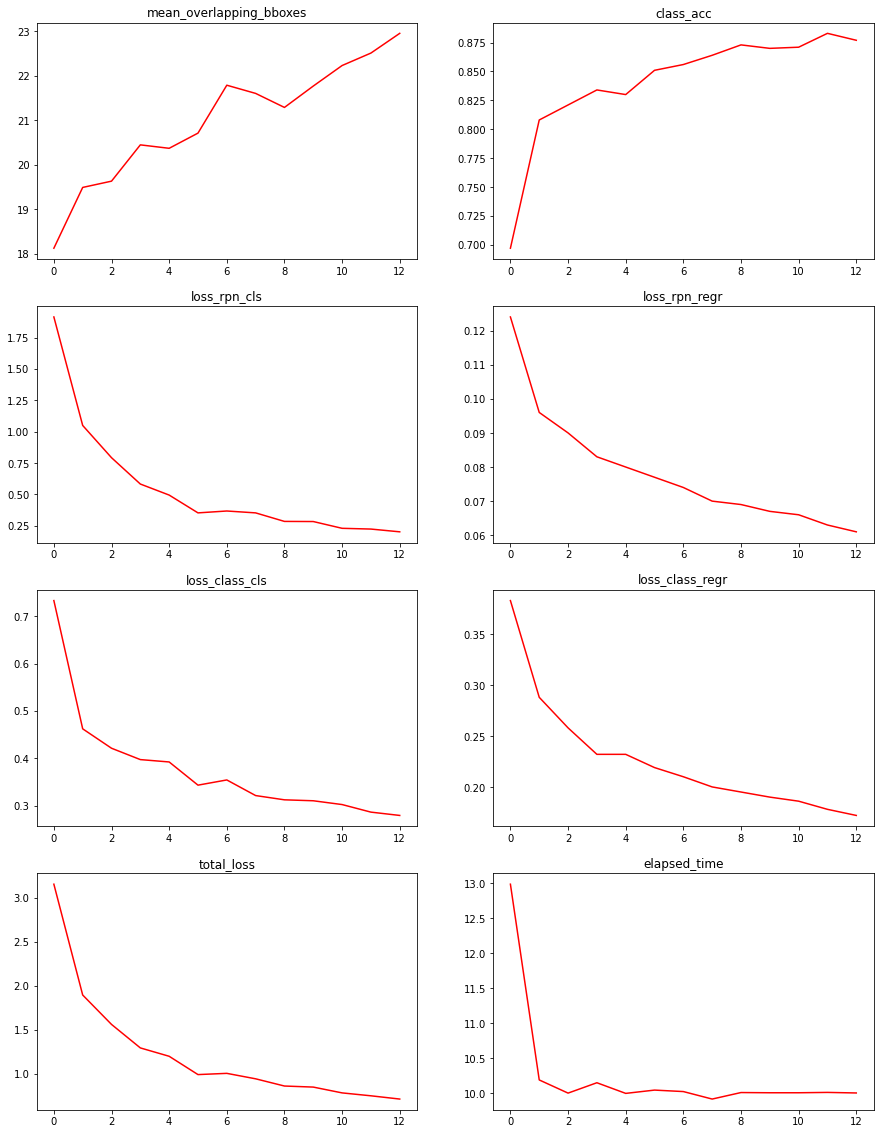

In [18]:
# Load the records
record_df = pd.read_csv(C.record_path)

r_epochs = len(record_df)

fig = plt.figure(figsize=(15,20))
plt.subplot(4,2,1)
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r')
plt.title('mean_overlapping_bboxes')

plt.subplot(4,2,2)
plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r')
plt.title('class_acc')

# plt.show()

# plt.figure(figsize=(15,5))

plt.subplot(4,2,3)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')

plt.subplot(4,2,4)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r')
plt.title('loss_rpn_regr')
# plt.show()
# plt.figure(figsize=(15,5))
plt.subplot(4,2,5)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
plt.title('loss_class_cls')

plt.subplot(4,2,6)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r')
plt.title('loss_class_regr')
# plt.show()
# plt.figure(figsize=(15,5))
plt.subplot(4,2,7)
plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
plt.title('total_loss')

plt.subplot(4,2,8)
plt.plot(np.arange(0, r_epochs), record_df['elapsed_time'], 'r')
plt.title('elapsed_time')

plt.savefig('train_progress.pdf')
plt.show()


## Load models
- Build models in the same way and load weights

In [19]:
input_shape_img = (None, None, 3)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(None, 4))

# define the base network (VGG here, can be Resnet50, Inception, etc)
shared_layers = nn_base(img_input, trainable=True)
# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios) # 9
rpn = rpn_layer(shared_layers, num_anchors)

classifier = classifier_layer(shared_layers, roi_input, C.num_rois, nb_classes=len(C.class_mapping))

model_rpn = Model(img_input, rpn[:2])
model_classifier = Model([img_input, roi_input], classifier)

# this is a model that holds both the RPN and the classifier, used to load/save weights for the models
model_all = Model([img_input, roi_input], rpn[:2] + classifier)

print('Loading weights from {}'.format(C.model_path))
# model_rpn.load_weights(C.model_path, by_name=True)
# model_classifier.load_weights(C.model_path, by_name=True)

model_rpn.load_weights('stuffs/model/rpnweights.h5')
model_classifier.load_weights('stuffs/model/classifierweights.h5')

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

Loading weights from stuffs\model/model_frcnn_vgg.hdf5


In [20]:
# import keras
# model_rpn2 = keras.models.load_model('stuffs/model/model_rpn.h5')
# model_classifier2 = keras.models.load_model('stuffs/model/model_classifier.h5')


In [21]:
# Switch key value for class mapping
class_mapping = C.class_mapping
class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

{0: 'apple', 1: 'banana', 2: 'orange', 3: 'bg'}


## Visulization

In [22]:
test_imgs = os.listdir(test_base_path)

imgs_path = []
for i in range(12):
    idx = np.random.randint(len(test_imgs))
    imgs_path.append(test_imgs[idx])

all_imgs = []

classes = {}

apple_82.jpg
Elapsed time = 11.152136087417603
[('apple', 99.90986585617065)]


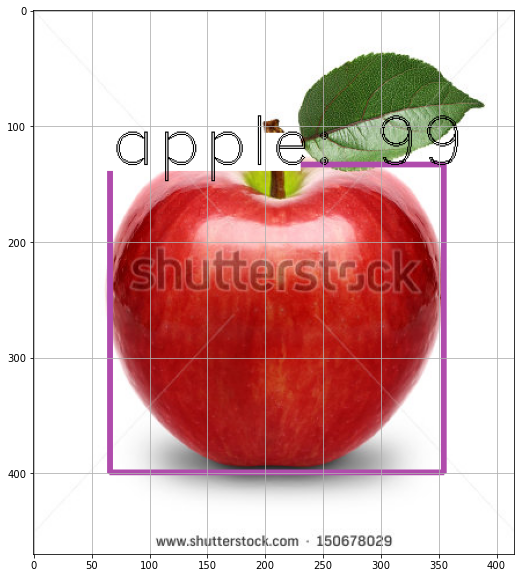

In [23]:
idx=0 
img_name='apple_82.jpg'
bbox_threshold = 0.7
print(img_name)
st = time.time()
filepath = os.path.join(test_base_path, img_name)

# filepath = 'train_zip/train/mixed_10.jpg'
img = cv2.imread(filepath)

X, ratio = format_img(img, C)

X = np.transpose(X, (0, 2, 3, 1))

# get output layer Y1, Y2 from the RPN and the feature maps F
# Y1: y_rpn_cls
# Y2: y_rpn_regr
# [Y1, Y2, F] = model_rpn.predict(X)
[Y1, Y2] = model_rpn.predict(X)


# Get bboxes by applying NMS 
# R.shape = (300, 4)
R = rpn_to_roi(Y1, Y2, C, K.image_data_format(), overlap_thresh=0.7)

# convert from (x1,y1,x2,y2) to (x,y,w,h)
R[:, 2] -= R[:, 0]
R[:, 3] -= R[:, 1]

# apply the spatial pyramid pooling to the proposed regions
bboxes = {}
probs = {}

for jk in range(R.shape[0]//C.num_rois + 1):
    ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
    if ROIs.shape[1] == 0:
        break

    if jk == R.shape[0]//C.num_rois:
        #pad R
        curr_shape = ROIs.shape
        target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
        ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
        ROIs_padded[:, :curr_shape[1], :] = ROIs
        ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
        ROIs = ROIs_padded

    [P_cls, P_regr] = model_classifier.predict([X, ROIs])
    
    # Calculate bboxes coordinates on resized image
    for ii in range(P_cls.shape[1]):
        # Ignore 'bg' class
#         print(np.argmax(P_cls[0, ii, :]),(P_cls.shape[2] - 1))
        if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
            continue

        cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

        if cls_name not in bboxes:
            bboxes[cls_name] = []
            probs[cls_name] = []

        (x, y, w, h) = ROIs[0, ii, :]

        cls_num = np.argmax(P_cls[0, ii, :])
        try:
            (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
            tx /= C.classifier_regr_std[0]
            ty /= C.classifier_regr_std[1]
            tw /= C.classifier_regr_std[2]
            th /= C.classifier_regr_std[3]
            x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)
        except:
            pass
        bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
        probs[cls_name].append(np.max(P_cls[0, ii, :]))

all_dets = []

for key in bboxes:
    bbox = np.array(bboxes[key])

    new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.25)
    for jk in range(new_boxes.shape[0]):
        (x1, y1, x2, y2) = new_boxes[jk,:]

        # Calculate real coordinates on original image
        (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)

        cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),4)

        textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
        all_dets.append((key,100*new_probs[jk]))

        (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
        textOrg = (real_x1, real_y1-0)

        cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 1)
        cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
        cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 2, (0, 0, 0), 1)
        
print('Elapsed time = {}'.format(time.time() - st))
print(all_dets)
plt.figure(figsize=(10,10))
plt.grid()
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.savefig(img_name)
plt.show()

In [24]:
imgs_path = ['apple_82.jpg','apple_77.jpg','banana_82.jpg', 'orange_93.jpg','mixed_25.jpg']

apple_82.jpg
Elapsed time = 10.692396402359009
[('apple', 99.90986585617065)]


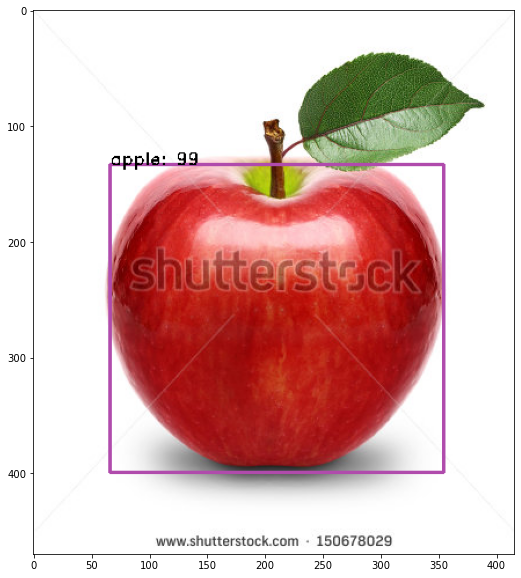

apple_77.jpg
Elapsed time = 12.39182186126709
[('apple', 99.86246824264526), ('apple', 99.80894923210144), ('apple', 99.07655715942383), ('apple', 96.92912697792053), ('apple', 95.37447690963745), ('apple', 78.83409857749939)]


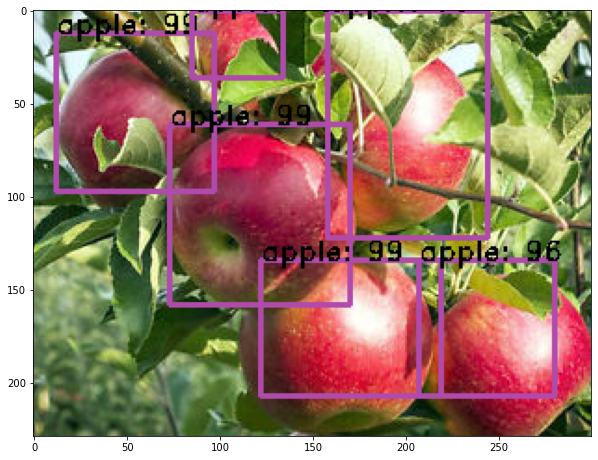

banana_82.jpg
Elapsed time = 14.479236841201782
[('banana', 98.9697515964508)]


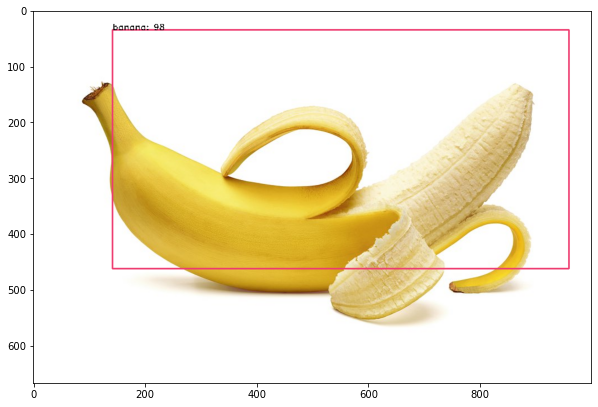

orange_93.jpg
Elapsed time = 14.512149810791016
[('orange', 99.80844259262085), ('orange', 99.65358972549438)]


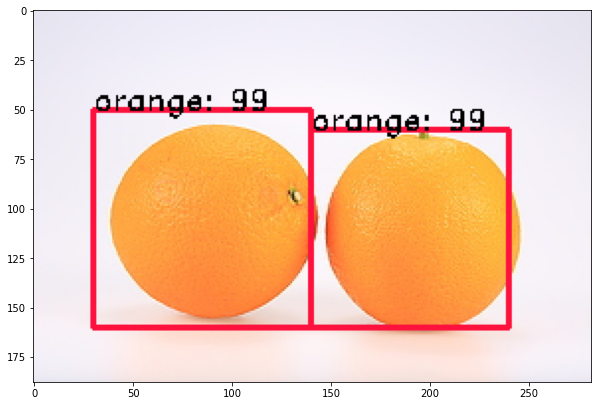

mixed_25.jpg
Elapsed time = 14.135478019714355
[('apple', 99.50106143951416), ('orange', 97.30362892150879)]


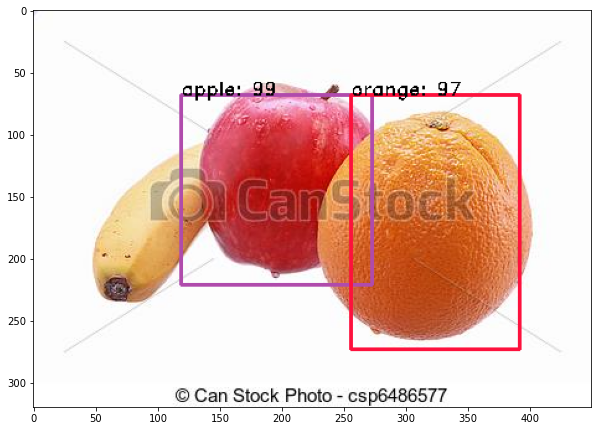

In [25]:
# # If the box classification value is less than this, we ignore this box
bbox_threshold = 0.5


for idx, img_name in enumerate(imgs_path):
    if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
        continue
    print(img_name)
    st = time.time()
    filepath = os.path.join(test_base_path, img_name)

    # filepath = 'train_zip/train/mixed_10.jpg'
    img = cv2.imread(filepath)

    X, ratio = format_img(img, C)

    X = np.transpose(X, (0, 2, 3, 1))

    # get output layer Y1, Y2 from the RPN and the feature maps F
    # Y1: y_rpn_cls
    # Y2: y_rpn_regr
    # [Y1, Y2, F] = model_rpn.predict(X)
    [Y1, Y2] = model_rpn.predict(X)


    # Get bboxes by applying NMS 
    # R.shape = (300, 4)
    R = rpn_to_roi(Y1, Y2, C, K.image_data_format(), overlap_thresh=0.7)

    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0]//C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0]//C.num_rois:
            #pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier.predict([X, ROIs])

        # Calculate bboxes coordinates on resized image
        for ii in range(P_cls.shape[1]):
            # Ignore 'bg' class
    #         print(np.argmax(P_cls[0, ii, :]),(P_cls.shape[2] - 1))
            if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.20) #less threshold means selecting less boxes
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]

            # Calculate real coordinates on original image
            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)

            cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2),(int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),2)

            textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
            all_dets.append((key,100*new_probs[jk]))

            (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
            textOrg = (real_x1, real_y1-0)

#             cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 1)
#             cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
            cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 0, 0), 1)

    print('Elapsed time = {}'.format(time.time() - st))
    print(all_dets)
    plt.figure(figsize=(10,10))
    # plt.grid()
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()

## Measure mAP

### mAP for test set

In [27]:
# This might takes a while to parser the data
test_imgs, _, _ = get_data(test_path)

Parsing annotation files
test_zip/test//apple_77.jpg 70 59 175 164 apple
test_zip/test//apple_77.jpg 12 22 105 111 apple
test_zip/test//apple_77.jpg 134 23 243 114 apple
test_zip/test//apple_77.jpg 107 125 216 229 apple
test_zip/test//apple_77.jpg 206 138 297 229 apple
test_zip/test//apple_78.jpg 9 8 343 336 apple
test_zip/test//apple_79.jpg 77 183 641 715 apple
test_zip/test//apple_80.jpg 155 105 453 436 apple
test_zip/test//apple_81.jpg 70 398 1387 1730 apple
test_zip/test//apple_82.jpg 65 122 365 404 apple
test_zip/test//apple_83.jpg 1 0 794 738 apple
test_zip/test//apple_84.jpg 64 84 484 456 apple
test_zip/test//apple_84.jpg 550 44 850 356 apple
test_zip/test//apple_84.jpg 196 1 559 273 apple
test_zip/test//apple_85.jpg 88 41 415 393 apple
test_zip/test//apple_86.jpg 112 144 173 211 apple
test_zip/test//apple_86.jpg 250 140 322 215 apple
test_zip/test//apple_87.jpg 42 134 358 455 apple
test_zip/test//apple_88.jpg 241 460 963 1229 apple
test_zip/test//apple_89.jpg 19 67 278 343 appl

In [28]:

mAPs = []
for idx, img_data in enumerate(test_imgs):
    T = {}
    P = {}
#     print(img_data['filepath'])
    print('{}/{}'.format(idx,len(test_imgs)))
    st = time.time()
    filepath = img_data['filepath']
    
    img = cv2.imread(filepath)

    X, fx, fy = format_img_map(img, C)

    # Change X (img) shape from (1, channel, height, width) to (1, height, width, channel)
    X = np.transpose(X, (0, 2, 3, 1))

    # get the feature maps and output from the RPN
    [Y1, Y2] = model_rpn.predict(X)


    R = rpn_to_roi(Y1, Y2, C, K.image_data_format(), overlap_thresh=0.7)

    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0] // C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois * jk:C.num_rois * (jk + 1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0] // C.num_rois:
            # pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0], C.num_rois, curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier.predict([X, ROIs])

        # Calculate all classes' bboxes coordinates on resized image (300, 400)
        # Drop 'bg' classes bboxes
        for ii in range(P_cls.shape[1]):

            # If class name is 'bg', continue
            if np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            # Get class name
            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :] #predicted anchors from rpn layer and rpntoROI transformation ==> this is how we train the model
                                          #given anchor boxes and predict relative centres and w h 

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4 * cls_num:4 * (cls_num + 1)] #predicted relative positions, w and h
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th) # gives predicted positions w and h
            except:
                pass
            bboxes[cls_name].append([C.rpn_stride * x, C.rpn_stride * y, C.rpn_stride * (x + w), C.rpn_stride * (y + h)]) # real box coordinates
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        # Apply non-max-suppression on final bboxes to get the output bounding boxes, 
        # Calculate the IoU with 'Last' most prob box and other boxes in the list. If the IoU is larger than overlap_threshold, delete the box from list
        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.25) # smaller threshold means selecting less boxes
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk, :]
            det = {'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'class': key, 'prob': new_probs[jk]}
            all_dets.append(det)


#     print('Elapsed time = {}'.format(time.time() - st))
    t, p = get_map(all_dets, img_data['bboxes'], (fx, fy))
    for key in t.keys():
        if key not in T:
            T[key] = []
            P[key] = []
        T[key].extend(t[key])
        P[key].extend(p[key])
    all_aps = []
    for key in T.keys():
        ap = average_precision_score(T[key], P[key])
        print('{} AP: {}'.format(key, ap))
        all_aps.append(ap)
    print('mAP = {}'.format(np.mean(np.nan_to_num(np.array(all_aps)))))
    mAPs.append(np.mean(np.nan_to_num(np.array(all_aps))))

    
# print()
print('mean average precision:', np.mean(np.array(mAPs)))

0/60
apple AP: 1.0
mAP = 1.0
1/60
apple AP: 1.0
mAP = 1.0
2/60
apple AP: 1.0
mAP = 1.0
3/60
apple AP: 1.0
mAP = 1.0
4/60
apple AP: 1.0
mAP = 1.0
5/60
apple AP: 1.0
mAP = 1.0
6/60
apple AP: 1.0
mAP = 1.0
7/60
apple AP: 0.6190476190476191
mAP = 0.6190476190476191
8/60
apple AP: 1.0
mAP = 1.0
9/60
apple AP: 0.8333333333333333
mAP = 0.8333333333333333
10/60
apple AP: 1.0
mAP = 1.0
11/60
apple AP: 1.0
mAP = 1.0
12/60
apple AP: 1.0
mAP = 1.0
13/60
apple AP: 1.0
mAP = 1.0
14/60
apple AP: 1.0
mAP = 1.0
15/60
apple AP: 1.0
mAP = 1.0
16/60
apple AP: 1.0
mAP = 1.0
17/60
apple AP: 1.0
mAP = 1.0
18/60
apple AP: 1.0
mAP = 1.0
19/60
banana AP: 0.3333333333333333
mAP = 0.3333333333333333
20/60
banana AP: 0.7
mAP = 0.7
21/60
banana AP: 1.0
mAP = 1.0
22/60
banana AP: 0.8333333333333333
mAP = 0.8333333333333333
23/60
banana AP: 0.75
mAP = 0.75
24/60
banana AP: 1.0
mAP = 1.0
25/60
banana AP: 0.3333333333333333
apple AP: nan
mAP = 0.16666666666666666
26/60


C:\Users\schro\.conda\envs\TF\lib\site-packages\sklearn\metrics\_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


banana AP: 1.0
mAP = 1.0
27/60
banana AP: 1.0
mAP = 1.0
28/60
banana AP: 0.8666666666666667
mAP = 0.8666666666666667
29/60
banana AP: 0.6666666666666666
mAP = 0.6666666666666666
30/60
banana AP: 1.0
mAP = 1.0
31/60
banana AP: 0.6666666666666667
mAP = 0.6666666666666667
32/60
banana AP: 0.9166666666666665
mAP = 0.9166666666666665
33/60
banana AP: 0.75
mAP = 0.75
34/60
banana AP: 1.0
mAP = 1.0
35/60
banana AP: 0.5
mAP = 0.5
36/60
banana AP: 1.0
mAP = 1.0
37/60
orange AP: 0.7857142857142857
apple AP: 1.0
mAP = 0.8928571428571428
38/60
apple AP: 1.0
banana AP: 1.0
orange AP: 1.0
mAP = 1.0
39/60
apple AP: 1.0
orange AP: 1.0
banana AP: 1.0
mAP = 1.0
40/60
banana AP: 1.0
apple AP: 1.0
mAP = 1.0
41/60
apple AP: 1.0
orange AP: 1.0
banana AP: 1.0
mAP = 1.0
42/60
orange AP: 1.0
banana AP: nan
mAP = 0.5
43/60
orange AP: 1.0
mAP = 1.0
44/60
orange AP: 0.95
mAP = 0.95
45/60
orange AP: 1.0
mAP = 1.0
46/60
orange AP: 1.0
mAP = 1.0
47/60
orange AP: 1.0
mAP = 1.0
48/60
orange AP: 1.0
mAP = 1.0
49/60
ora

In [29]:
mAP = [mAP for mAP in mAPs if str(mAP)!='nan']
mean_average_prec = round(np.mean(np.array(mAP)), 3)
print('After training %dk batches, the mean average precision for test set is %0.3f'%(len(record_df), mean_average_prec))


After training 13k batches, the mean average precision for test set is 0.912


### mAP for train set
- It is better to see both train and test performance under same metric for hyperparameters tuning

In [30]:
# This might takes a while to parser the data
train_imgs, _, _ = get_data(train_path)

mAPs = []
for idx, img_data in enumerate(train_imgs):
    T = {}
    P = {}
#     print(img_data['filepath'])
    print('{}/{}'.format(idx,len(train_imgs)))
    st = time.time()
    filepath = img_data['filepath']
    
    img = cv2.imread(filepath)

    X, fx, fy = format_img_map(img, C)

    # Change X (img) shape from (1, channel, height, width) to (1, height, width, channel)
    X = np.transpose(X, (0, 2, 3, 1))

    # get the feature maps and output from the RPN
    [Y1, Y2] = model_rpn.predict(X)


    R = rpn_to_roi(Y1, Y2, C, K.image_data_format(), overlap_thresh=0.7)

    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0] // C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois * jk:C.num_rois * (jk + 1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0] // C.num_rois:
            # pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0], C.num_rois, curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier.predict([X, ROIs])

        # Calculate all classes' bboxes coordinates on resized image (300, 400)
        # Drop 'bg' classes bboxes
        for ii in range(P_cls.shape[1]):

            # If class name is 'bg', continue
            if np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            # Get class name
            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :] #predicted anchors from rpn layer and rpntoROI transformation ==> this is how we train the model
                                          #given anchor boxes and predict relative centres and w h 

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4 * cls_num:4 * (cls_num + 1)] #predicted relative positions, w and h
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th) # gives predicted positions w and h
            except:
                pass
            bboxes[cls_name].append([C.rpn_stride * x, C.rpn_stride * y, C.rpn_stride * (x + w), C.rpn_stride * (y + h)]) # real box coordinates
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        # Apply non-max-suppression on final bboxes to get the output bounding boxes, 
        # Calculate the IoU with 'Last' most prob box and other boxes in the list. If the IoU is larger than overlap_threshold, delete the box from list
        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.25) # smaller threshold means selecting less boxes
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk, :]
            det = {'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'class': key, 'prob': new_probs[jk]}
            all_dets.append(det)


#     print('Elapsed time = {}'.format(time.time() - st))
    t, p = get_map(all_dets, img_data['bboxes'], (fx, fy))
    for key in t.keys():
        if key not in T:
            T[key] = []
            P[key] = []
        T[key].extend(t[key])
        P[key].extend(p[key])
    all_aps = []
    for key in T.keys():
        ap = average_precision_score(T[key], P[key])
        print('{} AP: {}'.format(key, ap))
        all_aps.append(ap)
    print('mAP = {}'.format(np.mean(np.nan_to_num(np.array(all_aps)))))
    mAPs.append(np.mean(np.nan_to_num(np.array(all_aps))))

# print()
print('mean average precision for train set:', np.mean(np.array(mAPs)))


Parsing annotation files
train_zip/train//apple_1.jpg 8 14 331 349 apple
train_zip/train//apple_10.jpg 56 99 1413 1419 apple
train_zip/train//apple_11.jpg 213 33 459 258 apple
train_zip/train//apple_11.jpg 1 30 188 280 apple
train_zip/train//apple_11.jpg 116 4 337 220 apple
train_zip/train//apple_12.jpg 43 21 350 353 apple
train_zip/train//apple_13.jpg 415 261 720 567 apple
train_zip/train//apple_13.jpg 105 426 393 691 apple
train_zip/train//apple_13.jpg 194 290 476 545 apple
train_zip/train//apple_14.jpg 318 146 680 511 apple
train_zip/train//apple_15.jpg 643 364 1396 1046 apple
train_zip/train//apple_16.jpg 14 44 270 300 apple
train_zip/train//apple_17.jpg 113 258 583 700 apple
train_zip/train//apple_18.jpg 144 136 470 411 apple
train_zip/train//apple_19.jpg 158 116 1264 1143 apple
train_zip/train//apple_2.jpg 37 52 205 222 apple
train_zip/train//apple_20.jpg 23 55 457 497 apple
train_zip/train//apple_21.jpg 97 126 346 379 apple
train_zip/train//apple_21.jpg 314 111 594 385 apple
tra

In [32]:
mAP = [mAP for mAP in mAPs if str(mAP)!='nan']
mean_average_prec = round(np.mean(np.array(mAP)), 3)
print('After training %dk batches, the mean average precision for train set is %0.3f'%(len(record_df), mean_average_prec))


After training 13k batches, the mean average precision for train set is 0.924


# Conclusion

- In this work, I built a faster RCNN model to detect three kinds of fruits: banana, apple and orange.
- This is the best model from my simple hyperparameter tuning.
- Using mean average precision for measuring the performance of the model, I get 0.912 for test image set and 0.924 for the train image set.
- Note that the hyper parameter tuning I have done in the work is one dimensional, meaning I just touch one hyperparameter at one time. Future improvments will involve multidimensional random walk on hyperparameters tuning.
- I could also try to implement the model to some more complicated dataset.

# References
- Original paper: Ren, S., He, K., Girshick, R., & Sun, J. (2015). Faster r-cnn: Towards real-time object detection with region proposal networks. In Advances in neural information processing systems (pp. 91-99).
- Fei-Fei Li, Ranjay Krishna, Danfei Xu Lecture slides 12
- Github repository: https://github.com/RockyXu66/Faster_RCNN_for_Open_Images_Dataset_Keras